In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager as fm
import matplotlib as mpl
from  matplotlib import cm
from collections import Counter
import sys
import json
# text analysis
from wordcloud import WordCloud

# part 1: basic statistics

In [407]:
num_sent, num_read, num_filled = 100, 89, 50

# part 2: survey report

In [425]:
def get_chart_data(df):
    
    data = df.answer.tolist()
    data_dict = Counter(data)
    data_x = list(data_dict.keys())
    data_y = list(data_dict.values())
    y_sum = df.shape[0]
    
    return data_x, data_y, y_sum

# bar chart
def chart_bar(df):
    
    data_x, data_y, y_sum = get_chart_data(df)[0], get_chart_data(df)[1], get_chart_data(df)[2]
    plt.bar(data_x, data_y, 0.4, color='g', alpha=0.6)
    #plt.title('Histogram')
    plt.ylabel('Count')
    plt.xlabel('Choice')

    y_max = max(data_y) + max(data_y) / 6
    plt.ylim([0, y_max])

    #y_sum = sum(data_y)
    percentage = [x / y_sum for x in data_y]

    #for x, y in enumerate(data_y):
        #plt.text(x, y + y_max / 20, str(round(percentage[x], 2)), ha='center')
    
    plt.savefig('output/bar_chart.jpg')
    plt.show()
    
    
# pie chart
def chart_pie(df):
    
    data_x, data_y = get_chart_data(df)[0], get_chart_data(df)[1]
    fig, ax = plt.subplots(figsize=(6,6))
    colors = cm.rainbow(np.arange(len(data_y))/len(data_y))
    ax.pie(data_y, labels=data_x, autopct='%1.1f%%',
            shadow=False, startangle=170,colors=colors)
    ax.axis('equal')
    #plt.savefig('pie.jpg')
    
    plt.savefig('output/pie_chart.jpg')
    plt.show()
    
    
# multi-choice data
def get_multi_choice_question_df(df_multi):
    
    df_answer_multi_row = df_multi.answer.str.split(',',expand=True)

    answer_list = []
    for i in range(4):
        r = list(df_answer_multi_row.iloc[:,i])
        answer_list.append(r)

    answer_list = sum(answer_list, [])
    answer_list_dropna = list(filter(None, answer_list))
    #print (answer_list_dropna)
    answer_df = pd.DataFrame(answer_list_dropna, columns=['answer'])
    
    return answer_df

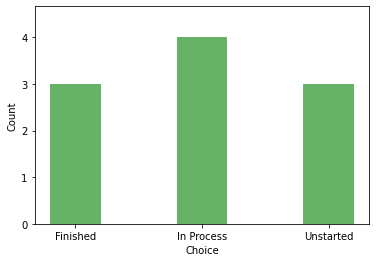

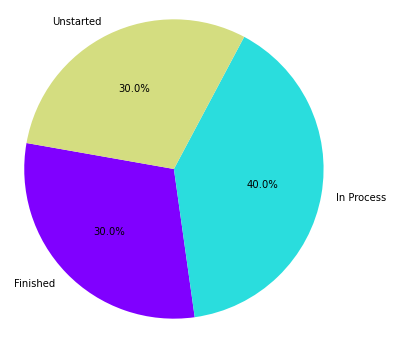

In [426]:
# 1.single-choice question

## bar chart
df_single = pd.read_csv('data/mock_single_choice.csv')
chart_bar(df_single)

## pie chart
chart_pie(df_single)

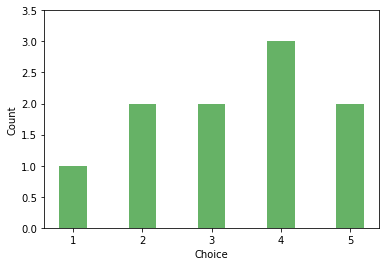

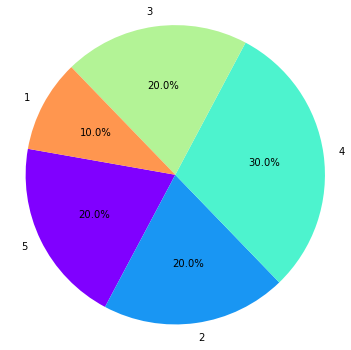

In [427]:
# 2.rating question

## bar chart
df_rating = pd.read_csv('data/mock_rating.csv')
chart_bar(df_rating)

## pie chart
chart_pie(df_rating)

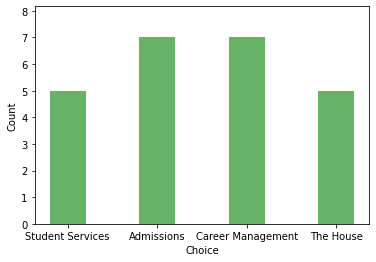

In [428]:
# 3.multi-choice question

## bar chart
df_multi = pd.read_csv('data/mock_multi_choice.csv')
answer_df = get_multi_choice_question_df(df_multi)
chart_bar(answer_df)

In [412]:
# 4.text question analysis

In [413]:
# save text answers as txt file
def get_text_answer_only(df_text):
    
    df_text_answer = df_text.answer
    df_text_answer.to_csv('data/mock_text_only.txt', sep='\t', index=False,header=None)
    
    return df_text_answer

# wordcloud
def plot_wordcloud(df_text):
    
    df_text_answer = get_text_answer_only(df_text)
    f = open(u'data/mock_text_only.txt','r',encoding='utf-8').read()

    wordcloud = WordCloud(
            background_color="white",
            width=1500,             
            height=960,           
            margin=10
            ).generate(f)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file('output/text_wordcloud.png')

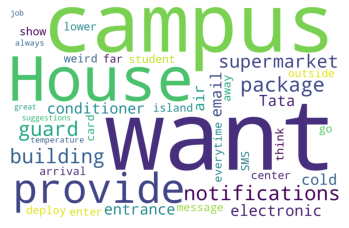

In [414]:
df_text = pd.read_csv('data/mock_text.csv')
plot_wordcloud(df_text)

In [415]:
# Topic Extraction

In [416]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn

import gensim
from gensim.models.ldamodel import LdaModel
import re

# clean text and turn all words into lowercase
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
en_stop = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

def get_text_split_data(df_text_answer):

    text_data = []

    for i in range(len(df_text_answer)):
        text = df_text_answer[i]
        text_split = prepare_text_for_lda(text)
        text_data.append(text_split)

    return text_data
    
def get_topics(text_data):
    
    dictionary = corpora.Dictionary(text_data) #use gensim.Dictionary to generate a bad-of-words from textdata
    corpus = [dictionary.doc2bow(text) for text in text_data]

    NUM_TOPICS = 5 # define number of topics to be generated
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,              
                                               num_topics = NUM_TOPICS,
                                               id2word=dictionary,
                                               passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=4)
    #for topic in topics:
        #print(topic)
    
    return topics

def get_topics_formatted(df_text):
    
    df_text_answer = get_text_answer_only(df_text)
    text_data = get_text_split_data(df_text_answer)
    text_topics = get_topics(text_data)
    
    topic_list = []
    for i in range(len(text_topics)):
        str = text_topics[i][1]
        str = re.sub("[\u4e00-\u9fa5\0-9\,\.]", " ", str)
        str = re.sub("\s+", ",", str.strip())
        topic_list.append(str)
        
    return topic_list

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/scarlett/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/scarlett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [417]:
text_topics = get_topics_formatted(df_text)
text_topics

['guard,electronic,entrance,student',
 'provide,notification,house,package',
 'campus,supermarket,island,outside',
 'building,conditioner,always,temperature',
 'message,package,house,notification']

# part 3: raw answers

In [419]:
df_single

user_id   submission time      answer
0        1  2021/10/14 12:30    Finished
1        2  2021/10/14 12:30    Finished
2        3  2021/10/14 12:30    Finished
3        4  2021/10/14 15:00  In Process
4        5  2021/10/14 12:30  In Process
5        6  2021/10/14 12:30  In Process
6        7  2021/10/14 12:30  In Process
7        8  2021/10/14 13:00   Unstarted
8        9  2021/10/14 14:00   Unstarted
9       10  2021/10/14 12:30   Unstarted

In [420]:
df_multi

user_id   submission time  \
0        1  2021/10/14 12:30   
1        2  2021/10/14 12:30   
2        3  2021/10/14 12:30   
3        4  2021/10/14 15:00   
4        5  2021/10/14 12:30   
5        6  2021/10/14 12:30   
6        7  2021/10/14 12:30   
7        8  2021/10/14 13:00   
8        9  2021/10/14 14:00   
9       10  2021/10/14 12:30   

                                              answer  
0                        Student Services,Admissions  
1                        Student Services,Admissions  
2                        Student Services,Admissions  
3                       Admissions,Career Management  
4                        Career Management,The House  
5                        Career Management,The House  
6                        Career Management,The House  
7  Admissions,Student Services,Career Management,...  
8             Admissions,The House,Career Management  
9      Admissions,Career Management,Student Services

In [421]:
df_rating

user_id   submission time  answer
0        1  2021/10/14 12:30       5
1        2  2021/10/14 12:30       5
2        3  2021/10/14 12:30       2
3        4  2021/10/14 15:00       4
4        5  2021/10/14 12:30       2
5        6  2021/10/14 12:30       4
6        7  2021/10/14 12:30       4
7        8  2021/10/14 13:00       3
8        9  2021/10/14 14:00       1
9       10  2021/10/14 12:30       3

In [422]:
df_text

user_id   submission time  \
0        1  2021/10/14 12:30   
1        2  2021/10/14 12:30   
2        3  2021/10/14 12:30   
3        4  2021/10/14 15:00   
4        5  2021/10/14 12:30   
5        6  2021/10/14 12:30   
6        7  2021/10/14 12:30   
7        8  2021/10/14 13:00   
8        9  2021/10/14 14:00   
9       10  2021/10/14 12:30   

                                              answer  
0  Could the House provide SMS or email notificat...  
1  I want the House provide message notifications...  
2  I want the House provide email notifications f...  
3  I think Tata center should deploy an electroni...  
4  Can Tata have an electronic entrance guard? It...  
5  I want a supermarket on campus. The supermarke...  
6  Could we have a on-campus supermarket? I don't...  
7  The air conditioner in the buildings are too c...  
8  Can you lower the temperature of the air condi...  
9   No suggestions. The campus is doing a great job!